In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# 전처리된 데이터 셋 불러오기

In [2]:
# 주피터노트북 단축키
# https://nittaku.tistory.com/428

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import datetime, time
import re
import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

## DataFrame 2가지 존재 ( 원본, 중복제거 )

- 중복제거 데이터가 성능이 뛰어남.

In [4]:
# 중복 제거 X
df_news = pd.read_csv('./Data_Set/news_data_preprocessing.csv', engine= 'python',encoding = 'utf-8')
# 중복 제거 O
df_news_overlap = pd.read_csv('./Data_Set/news_data_preprocessing_duplicate.csv', engine= 'python',encoding = 'utf-8')

In [5]:
df_news.columns

Index(['Unnamed: 0', 'date', 'year', 'month', 'day', 'title', 'nouns_title',
       'press', 'contents', 'nouns_contents'],
      dtype='object')

In [6]:
df_news = df_news.loc[:,['date', 'year', 'month', 'day', 'title', 'nouns_title',
       'press', 'contents', 'nouns_contents']]
df_news_overlap = df_news_overlap.loc[:,['date', 'year', 'month', 'day', 'title', 'nouns_title',
       'press', 'contents', 'nouns_contents']]

In [7]:
# 시각화 글자 깨짐 방지
if os.name == 'posix':
    plt.rc("font", family="Malgun Gothic")
else:
    plt.rc("font", family="Malgun Gothic")

# 레이블링 / 데이터 셋 분할 / 정수 인코딩

- 긍정 부정 단어를 분류 기초 방식. 따라서 보충이 필요.

**※논문 참고(계산법) : http://www.koreascience.kr/article/JAKO201719363360793.pdf**

## 레이블링

In [8]:
pos_word = []
neg_word = []
pos_neg = []

pos = open('./pos_neg_dictionary/positive_word.txt', 'r', encoding='UTF-8')

while True:
    line = pos.readline().rstrip()
    pos_word.append(line)
    
    if not line:
        break

pos.close()

neg = open('./pos_neg_dictionary/negative_word.txt', 'r', encoding='UTF-8')

while True:
    line = neg.readline().rstrip()
    neg_word.append(line)
    
    if not line:
        break

neg.close()

In [9]:
# 마지막 인덱스 '' 제거
pos_word = pos_word[:-1]
neg_word = neg_word[:-1]
pos_neg = pos_word + neg_word

In [10]:
pd.set_option('mode.chained_assignment',  None) # 경고 off
state = list()

for x in df_news_overlap['nouns_contents']:
    words = x.split(' ')
    total, p, n = 0, 0, 0
    for i in words:
        if i in pos_word:
            p += 1
        elif i in neg_word:
            n += 1
    
    # 기사 제목당 긍정갯수 - 부정 갯수
    total = p - n
    if total > 0:
        state.append(1)
    elif total == 0:
        state.append(0)
    else:
        state.append(-1)

print('부정:%d   긍정:%d   중립:%d' % (state.count(-1), state.count(1), state.count(0)))
df_news_overlap['label'] = 0
for i in range(len(state)):
    df_news_overlap['label'][i] = state[i]

부정:1432   긍정:13720   중립:4151


## Train Set / Test Set 분할

- Train Set과 Test Set으로 분류 ( 7:3 )
- train_test_split() 함수에서 shuffle / default option : True.
- stratify 옵션 중요 !!
- Pos : 개선 / Neg : 불만

**참고 https://sosoeasy.tistory.com/488 / https://teddylee777.github.io/scikit-learn/train-test-split**

In [11]:
from sklearn.model_selection import train_test_split

### 데이터 분할 시 테이블 변경 가능

In [12]:
# 필요한 데이터만 추출 / 컬럼명 변경
# 80% / 20% 으로 분할
x_train, x_test = train_test_split(df_news_overlap.loc[:,['date', 'year', 'month', 'day','nouns_contents', 'label']], test_size = 0.3, shuffle = True, random_state = 1234)

In [13]:
# 인덱스 번호 새로 부여.
x_train.reset_index(inplace=True)
x_train.drop(['index'], axis=1, inplace=True)

x_test.reset_index(inplace=True)
x_test.drop(['index'], axis=1, inplace=True)

In [14]:
# 2개의 데이터 프레임 생성
print(type(x_train), type(x_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


### Train Set / Test Set 시각화 및 레이블 현황

**참고 : isin() 문법 참고 : https://rfriend.tistory.com/460**

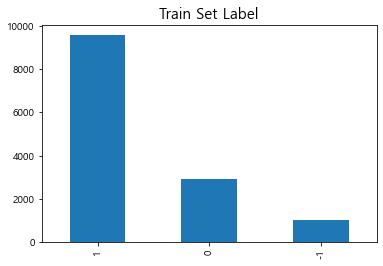

In [15]:
x_train['label'].value_counts().plot(kind='bar')
plt.title('Train Set Label', size = 15)
plt.show()

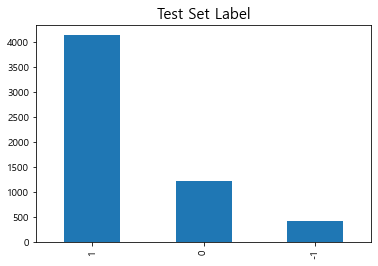

In [16]:
x_test['label'].value_counts().plot(kind='bar')
plt.title('Test Set Label', size = 15)
plt.show()

In [17]:
# Train_Set 레이블 현황 갯수
print('Train_Set  긍정(1) : {} \n\t   중립(0) : {} \n\t   부정(-1) : {} \n\t   총 합계 : {}'.format(len(x_train[x_train['label'].isin([1])]), len(x_train[x_train['label'].isin([0])]), len(x_train[x_train['label'].isin([-1])]), len(x_train)))
print()
# Test_Set 레이블 현황 갯수
print('Test_Set   긍정(1) : {} \n\t   중립(0) : {} \n\t   부정(-1) : {} \n\t   총 합계 : {}'.format(len(x_test[x_test['label'].isin([1])]), len(x_test[x_test['label'].isin([0])]), len(x_test[x_test['label'].isin([-1])]), len(x_test)))

Train_Set  긍정(1) : 9581 
	   중립(0) : 2920 
	   부정(-1) : 1011 
	   총 합계 : 13512

Test_Set   긍정(1) : 4139 
	   중립(0) : 1231 
	   부정(-1) : 421 
	   총 합계 : 5791


## Convert to two_dimensional list

In [18]:
x_train.head(2)

,date,year,month,day,nouns_contents,label
0,2020-05-07,2020,5,7,대 구 은행 DGB 금융 전체 에서 차지 순이익 기여 723% 로 코로나 19 파장...,-1
1,2019-12-02,2019,12,2,DGB 대 구 은행 2일 본점 에서 ㈔ 중소기업 융합 대구 경북 연합 회 지역 중소...,1


In [19]:
x_test.head(2)

,date,year,month,day,nouns_contents,label
0,2020-07-16,2020,7,16,구미시 16일 구미 종합 사회 복지관 에서 대 적십자사 경상북도지사 회장 류 시문 ...,1
1,2020-05-28,2020,5,28,이번 지정 되다 서비스 SK 텔레콤 디지털 실명 확인 증표 기반 비대 실명 확인 서...,1


In [20]:
# 리스트로 변환 후 체크 
# 6263
x_train_words = list()
for title_words in x_train['nouns_contents']:
    x_train_words.append(list(title_words.split(' ')))

# 2685
x_test_words = list()
for title_words in x_test['nouns_contents']:
    x_test_words.append(list(title_words.split(' ')))

In [21]:
print(x_train_words[:2])

[['대', '구', '은행', 'DGB', '금융', '전체', '에서', '차지', '순이익', '기여', '723%', '로', '코로나', '19', '파장', '인하다', '시장', '금리', '하락', '영향', '을', '받다', '이자', '이익', '감소', '다만', '대', '구', '은행', '원화', '대출', '금은', '전', '년', '대비', '50%', '증가', '건전성'], ['DGB', '대', '구', '은행', '2일', '본점', '에서', '㈔', '중소기업', '융합', '대구', '경북', '연합', '회', '지역', '중소기업', '지원', '을', '통한', '경제', '활성화', '위해', '경영', '컨설팅', '및', '교육', '지원', '사업', '등', '을', '위', '포괄', '적', '업무', '협약', 'MOU', '을', '체결', '1993년', '설립', '되다']]


In [22]:
print(x_test_words[:2])

[['구미시', '16일', '구미', '종합', '사회', '복지관', '에서', '대', '적십자사', '경상북도지사', '회장', '류', '시문', 'DGB', '대구', '은행', '경북', '본부', '대표', '김윤국', '도움', '준비', '삼계탕', '600', '그릇', '을', '어르신', '에게', '전달', '찾아가다', '들다', '도시락', '행사'], ['이번', '지정', '되다', '서비스', 'SK', '텔레콤', '디지털', '실명', '확인', '증표', '기반', '비대', '실명', '확인', '서비스', '저축은행', '중앙회', '저축은행', '공동', '전산', '망', '기반', '신원', '증명', '간소화', '플랫폼', 'DGB', '대', '구', '은행', '안면', '인식', '기술', '활용', '비대', '실명', '확인', '서비스']]


## Integer Encoding
- 토큰화 한 단어를 컴퓨터가 인식하도록 정수 인코딩 수행

In [23]:
from keras.preprocessing.text import Tokenizer

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_words)
tokenizer.fit_on_texts(x_test_words)

In [25]:
x_train_int = tokenizer.texts_to_sequences(x_train_words)

In [26]:
x_test_int = tokenizer.texts_to_sequences(x_test_words)

In [27]:
print(x_train_int[:2])

[[4, 5, 1, 2, 7, 601, 8, 1083, 80, 803, 8375, 13, 25, 26, 8376, 388, 187, 59, 413, 703, 3, 86, 377, 141, 206, 1220, 4, 5, 1, 1074, 18, 673, 32, 113, 94, 1206, 119, 1084], [2, 4, 5, 1, 398, 22, 8, 5237, 121, 1869, 6, 35, 894, 230, 10, 121, 24, 3, 152, 123, 102, 19, 108, 495, 23, 315, 24, 88, 12, 3, 36, 2034, 40, 54, 47, 1240, 3, 107, 4263, 631, 16]]


In [28]:
print(x_test_int[:2])

[[721, 361, 337, 287, 78, 591, 8, 4, 215, 4801, 34, 1590, 3640, 2, 6, 1, 35, 268, 132, 1050, 1060, 1191, 1108, 3508, 7703, 3, 1014, 125, 61, 1463, 664, 785, 73], [49, 700, 16, 31, 155, 180, 82, 547, 276, 2878, 209, 84, 547, 276, 31, 634, 1377, 634, 390, 3196, 1961, 209, 2424, 2325, 2754, 169, 2, 4, 5, 1, 800, 611, 117, 212, 84, 547, 276, 31]]


## 제목 길이 기준 분포 확인

In [29]:
# print('최대 길이(단어의 수) :', max([(len(i)) for i in x_train_int]))
# print('평균 길이 :', sum([len(i) for i in x_train_int]) // len(x_train_int))
# plt.figure(figsize = (12, 8))
# plt.hist([len(i) for i in x_train_int], bins=90)
# plt.xlabel('length fo Data')
# plt.ylabel('number fo Data')
# plt.show()

In [30]:
# print('최대 길이(단어의 수) :', max([(len(i)) for i in x_test_int]))
# print('평균 길이 :', sum([len(i) for i in x_test_int]) // len(x_test_int))
# plt.figure(figsize = (12, 8))
# plt.hist([len(i) for i in x_test_int], bins=90)
# plt.xlabel('length fo Data')
# plt.ylabel('number fo Data')
# plt.show()

## Padding

- 길이를 길게 잡으면 학습 시간이 오래 걸림 --> 데이터 손실 최소화 + 효율성
- 데이터가 비교적 적은 부분은 패딩으로 처리하는게 좋음.
- maxlen의 인자로 정수를 주면, 해당 정수로 모든 문서의 길이를 동일

**Ex) 길이가 5인 리스트가 있다면 5보다 작은 인덱스 값들은 0으로 패딩되고 5보다 큰 인덱스들은 즉, 6번째 인덱스부터는 데이터가 손실됨.**<br><br>
**참고<br> https://wikidocs.net/83544 (2/5 지점)<br>http://www.nextobe.com/2020/05/14/%EA%B0%80%EB%B3%80-%EA%B8%B8%EC%9D%B4-%EC%9E%85%EB%A0%A5-%EC%8B%9C%ED%80%80%EC%8A%A4%EC%97%90-%EB%8C%80%ED%95%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A4%80%EB%B9%84/<br>https://sig413.tistory.com/5**

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
# 각 인덱스 길이대로 정렬
x_train_int.sort(key=lambda x:len(x),reverse = True)
x_test_int.sort(key=lambda x:len(x),reverse = True)

In [33]:
def limit_len(front, back, reset_list):
    cnt = 0
    for s in reset_list:
        # if (front <= len(s) <= back):
        if len(s) <= back:
            cnt += 1
    print('전체 학습 데이터 중 길이가 {} 이상 {} 이하인 비율 : {:.2f}%'.format(front, back,( cnt / len(x_train_int)) * 100))

In [34]:
# min_len = 4 / max_len = 14
# 앞선 제목의 평균 길이 그래프를 보면 ( 4 <= idx_num <= 14 ) 범위를 벗어난 인덱스들은 데이터가 현저히 적음.
limit_len(0, 40, x_train_int)
limit_len(0, 55, x_train_int)

전체 학습 데이터 중 길이가 0 이상 40 이하인 비율 : 55.85%
전체 학습 데이터 중 길이가 0 이상 55 이하인 비율 : 99.47%


**일단 14이하인 것만 패딩 --> 나중에 시간되면 4이상 14이하인 부분만 패딩하도록 전처리 필요**
<br>
**pad_sequences post / defalut로 각각 한번씩 해주면 됨.**

In [35]:
max_len = 55

In [36]:
# 대문자 X_train
X_train = pad_sequences(x_train_int, maxlen = max_len)

In [37]:
# 대문자 X_test
X_test = pad_sequences(x_test_int, maxlen = max_len)

## One-Hot-Encoding

- 단어 집합의 크기를 벡터로 변환하고, 표현하고 싶은 단어 인덱스에 1의 값 부여하고, 다른 인덱스는 0을 부여하는 단어의 벡터 표현 방식
- 즉, 1개만 Hot(True)이고 나머지는 Cold(False)

※ 벡터 (1차원)  /  행렬 (2차원)  /  배열 (3차원)  /  텐서 (3차원 이상)
<br>
<br>
**참고 : https://godcode.tistory.com/9?category=908926**

In [38]:
tokenizer.word_index

{'은행': 1,
 'dgb': 2,
 '을': 3,
 '대': 4,
 '구': 5,
 '대구': 6,
 '금융': 7,
 '에서': 8,
 '장': 9,
 '지역': 10,
 '밝히다': 11,
 '등': 12,
 '로': 13,
 '있다': 14,
 '\xa0': 15,
 '되다': 16,
 '그룹': 17,
 '대출': 18,
 '위해': 19,
 '제': 20,
 '하고': 21,
 '본점': 22,
 '및': 23,
 '지원': 24,
 '코로나': 25,
 '19': 26,
 '이다': 27,
 '고객': 28,
 '지난': 29,
 '제공': 30,
 '서비스': 31,
 '전': 32,
 '기업': 33,
 '회장': 34,
 '경북': 35,
 '위': 36,
 '임성훈': 37,
 '김태오': 38,
 '2': 39,
 '적': 40,
 '진행': 41,
 '따르다': 42,
 '실시': 43,
 '지주': 44,
 '투자': 45,
 '부터': 46,
 '협약': 47,
 '사진': 48,
 '이번': 49,
 '증권': 50,
 '영업': 51,
 '원': 52,
 '수': 53,
 '업무': 54,
 '상품': 55,
 '기': 56,
 '까지': 57,
 'im': 58,
 '금리': 59,
 '직원': 60,
 '전달': 61,
 '적금': 62,
 '하이': 63,
 '센터': 64,
 '1': 65,
 '오다': 66,
 '통해': 67,
 '개': 68,
 '함께': 69,
 '뱅크': 70,
 '명': 71,
 '사랑': 72,
 '행사': 73,
 '지점': 74,
 '계열': 75,
 '대상': 76,
 '돼다': 77,
 '사회': 78,
 'bnk': 79,
 '순이익': 80,
 '식': 81,
 '디지털': 82,
 '부산': 83,
 '비대': 84,
 '카드': 85,
 '받다': 86,
 '기자': 87,
 '사업': 88,
 '경': 89,
 '지난해': 90,
 '신용': 91,
 '출시': 92,
 '▲'

In [39]:
len(tokenizer.word_index)

15668

## get dummies --> 원핫인코딩

In [40]:
# pd.get_dummies()로 쉽게 원핫인코딩 가능.

y_train = pd.get_dummies(x_train['label']).to_numpy()
y_test = pd.get_dummies(x_test['label']).to_numpy()

In [41]:
# y_train = list()
# y_test = list()
# X_train['label'].unique().tolist()

In [42]:
# # 1 / 0 / -1
# def one_hot_encoding(label):
#     one_hot_vector = [0] * len(X_train['label'].unique().tolist())
#     one_hot_vector[label+1] = 1
#     return one_hot_vector

# def right_answer():
#     for tr in X_train['label']:
#         y_train.append(one_hot_encoding(tr))
#     for te in X_test['label']:
#         y_test.append(one_hot_encoding(te))

# right_answer()

In [43]:
# if (len(y_train) + len(y_test)) == len(df_news_overlap['label']):
#     print('정상')
# else:
#     y_train = list()
#     y_test = list()
#     right_answer()
#     print('재확인 필요')

# y_train = np.array(y_train)
# y_test = np.array(y_test)

## 빈도 수가 낮은 단어 제거 --> 대기
- 빈도수가 낮은 단어 --> 학습에 영향이 크지 않음.
- 전처리를 통해 제거
- 패딩 --> 학습 시간 단축 및 최적의 효율성

**한두번 나온 단어가 그 문장의 감성을 표현할 수 있는 핵심단어 일수도?**

In [44]:
threshold = 2 # 임계치
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq += value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value
print('단어 집합(vocabulary)의 종류 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율: {:.2f}".format((rare_cnt / total_cnt) * 100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / words_freq) * 100)

단어 집합(vocabulary)의 종류 : 15668
등장 빈도가 1번 이하인 희귀 단어의 수: 5403
단어 집합에서 희귀 단어의 비율: 34.48
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.6988809884451159


In [45]:
vocab_size = total_cnt-rare_cnt
print(vocab_size)

10265


In [46]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')

In [47]:
x_train.head(2)

,date,year,month,day,nouns_contents,label
0,2020-05-07,2020,5,7,대 구 은행 DGB 금융 전체 에서 차지 순이익 기여 723% 로 코로나 19 파장...,-1
1,2019-12-02,2019,12,2,DGB 대 구 은행 2일 본점 에서 ㈔ 중소기업 융합 대구 경북 연합 회 지역 중소...,1


In [48]:
x_test.head(2)

,date,year,month,day,nouns_contents,label
0,2020-07-16,2020,7,16,구미시 16일 구미 종합 사회 복지관 에서 대 적십자사 경상북도지사 회장 류 시문 ...,1
1,2020-05-28,2020,5,28,이번 지정 되다 서비스 SK 텔레콤 디지털 실명 확인 증표 기반 비대 실명 확인 서...,1


In [49]:
x_train.to_csv('./Data_Set/X_train.csv')
x_test.to_csv('./Data_Set/X_test.csv')

# 모델링

- 성능 높이기 + 시각화 해서 파일로 만들기

**https://sieon-dev.tistory.com/15**

## GPU 체크
- NVIDIA GeForce RTX 2070 SUPER : 2개 (GPU index number : 0, 1)
- CPU :1 개 ( CPU index number : 0)

In [50]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [51]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [52]:
%matplotlib inline
# Function call stack:
# train_function -> train_function -> train_function
# 해당 줄로 오류 해결
# 참고 : https://www.freesion.com/article/71721347190/
tf.compat.v1.disable_eager_execution()

## 데이터셋 확인

In [53]:
from keras import models
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Input, LSTM, Activation, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, SpatialDropout1D, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model

In [54]:
print('X_train :', X_train.shape)
print('X_test :', X_test.shape)
print('y_train :', y_train.shape)
print('X_test :', y_test.shape)

X_train : (13512, 55)
X_test : (5791, 55)
y_train : (13512, 3)
X_test : (5791, 3)


## 옵티마이저 튜닝

- optimizers 정의 및 튜닝 ( Adam, SGD, RMSprop)
- 하이퍼 파라미터 튜닝

**val_loss 감소시키는 방법 : https://lsjsj92.tistory.com/353**

In [55]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0001, clipnorm=1., epsilon=None, amsgrad=False)

sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.0001, nesterov=False)

rmsprop = RMSprop(learning_rate=0.001, rho=0.9, decay=0.0001, epsilon=None)

## 모델 구축 및 데이터 학습

- val_accuracy도 점점 떨어지고 있는 것으로 봐서 네트워크가 과적합되는 것으로 보입니다. 과적합의 이유는 임베딩 레이어를 랜덤한 값에서부터 시작해서 학습시키기 때문에 각 단어를 나타내는 벡터의 품질

**모델 샘플 : https://www.kaggle.com/code/nafisur/keras-models-lstm-cnn-gru-bidirectional-glove/notebook**
<br><br>
**성능 개선 : https://wikidocs.net/142041**
<br><br>
**loss 함수 설명 : https://velog.io/@rcchun/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%86%90%EC%8B%A4%ED%95%A8%EC%88%98%EC%9D%98-%EC%A2%85%EB%A5%98#msemean-squared-error**
<br><br>
**LSTM / RNN / GRU 개념 : https://velog.io/@dong970827/RNN-LSTM-GRU-%EA%B0%9C%EB%85%90**

- 과적합 뜨는 이유
- 1. 긍정 80% / 부정 5% / 중립 15% (총 331개 Test Data) 데이터 갯수와 비율 때문이라고 판단.
- 2. 학습진행시 전체데이터에서 부정갯수가 가장 작은 편이므로, 긍정데이터에 대해서는 과적합

### LSTM ( 73 ~ 77% / 요약본 / 오차 작음)

In [56]:
# 하이퍼파라미터 : rmsprop / binary_crossentropy / 50 / 256 / 0.2
model_01 = Sequential()

model_01 = Sequential() # tensorflow.keras.models
model_01.add(Embedding(total_cnt, 100, input_length=max_len))
model_01.add(LSTM(128))
model_01.add(Dense(3, activation='softmax'))
model_01.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 55, 100)           1566800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 1,684,435
Trainable params: 1,684,435
Non-trainable params: 0
_________________________________________________________________


### LSTM 2 Layer + Dropout (64 ~ 66 % / 요약본 / 오차 큼)
- 의미 없음. 제일 성능 떨어짐

In [57]:
# 하이퍼파라미터 : adam / categorical_crossentropy / 50 / 512 / 0.2
model_02 = Sequential()

model_02.add(Embedding(total_cnt,100, mask_zero=True))
model_02.add(LSTM(64,dropout=0.7, recurrent_dropout=0.7,return_sequences=True))
model_02.add(LSTM(32,dropout=0.6, recurrent_dropout=0.6,return_sequences=False))
model_02.add(Dense(3, activation='softmax'))
model_02.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1566800   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,621,555
Trainable params: 1,621,555
Non-trainable params: 0
_________________________________________________________________


### CNN + Dropout ( 77 ~ 79 % / 요약본 / 오차 큼)

In [58]:
# 하이퍼파라미터 : adam / categorical_crossentropy / 100 / 128 / 0.2
model_03= Sequential()

model_03.add(Embedding(total_cnt, 100, input_length=max_len))
model_03.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', strides=1))
model_03.add(GlobalMaxPooling1D())
model_03.add(Dense(128, activation='relu'))
model_03.add(Dropout(0.8))
model_03.add(Dense(3, activation='softmax'))
model_03.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 55, 100)           1566800   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            19264     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 1,594,771
Trainable params: 1,594,771
Non-trainable params: 0
____________________________________________

### Bi GRU + Dropout ( 75 ~ 77% / 요약본 / 오차 매우 작음)

In [59]:
model_04 = Sequential()

model_04.add(Embedding(total_cnt, 100, input_length=max_len))
model_04.add(SpatialDropout1D(0.25))
model_04.add(Bidirectional(GRU(128)))
model_04.add(Dropout(0.5))

model_04.add(Dense(3, activation='softmax'))
model_04.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 55, 100)           1566800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 55, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               176640    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 1,744,211
Trainable params: 1,744,211
Non-trainable params: 0
_________________________________________________________________


### Bi LSTM (  )

In [60]:
model_05 = Sequential()

model_05.add(Embedding(total_cnt, 100, input_length=max_len))
model_05.add(Bidirectional(LSTM(128, dropout= 0.5, recurrent_dropout=0.5, return_sequences=True)))

# model_05.add(Bidirectional(LSTM(128, dropout= 0.7, recurrent_dropout=0.7)))
model_05.add(GRU(64))
model_05.add(Dense(64, activation='relu'))
model_05.add(Dropout(0.2))
model_05.add(Dense(3, activation='softmax'))
model_05.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 55, 100)           1566800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 55, 256)           234496    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                61824     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 1,867,475
Trainable params: 1,867,475
Non-trainable params: 0
____________________________________________

In [61]:
def learning(model):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    mc = ModelCheckpoint('bilstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    # categorical_crossentropy / binary_crossentropy / mse / sparse_categorical_crossentropy
    # softmax / sigmoid
    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])# 0.002 학습률
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=1024, validation_split = 0.2)
    return history

## 모델 성능 평가 및 저장

- 과적합 : https://stackoverflow.com/questions/50615396/validation-loss-increasing
- https://stackoverflow.com/questions/61342448/train-accuracy-increases-train-loss-is-stable-validation-loss-increases-valid

In [ ]:
model_num = model_05
history = learning(model_num)

In [ ]:
print('예측률 : {:.2f}%'.format(model_num.evaluate(X_test, y_test)[1] * 100))

In [ ]:
# 모델 저장
model_num.save('./Model_Evaluation/Multiclass_model_01.h5')

In [ ]:
# from keras.models import load_model
# loaded_model = load_model('./HyperParameter_ModelLayer/LSTM_Sigmoid.h5')
# print("\n 테스트 정확도 : {:.2f}%%".format(loaded_model.evaluate(X_test, y_test)[1] * 100))

## 데이터 학습 시각화

- 오버피팅 : https://untitledtblog.tistory.com/158

In [ ]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
                
plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r:', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label='training accuracy')
plt.plot(val_acc, 'r:', label='validation accuracy')
plt.legend()
plt.grid()

In [ ]:
predict = model_num.predict(X_test)

In [ ]:
predict_labels = np.argmax(predict, axis = 1)
original_labels = np.argmax(y_test, axis = 1)

# 그래프 시각화
<br>

**언론사별 / 월별 / 주중별기사 수량 확인**
**아직 제대로 진행 안됨...**

## 저장된 모델 불러오기 ( 다중 분류 3개이상 )

In [63]:
from keras.models import load_model

model_num = load_model('./Model_Evaluation/Multiclass_model_05_(61.84%).h5')
print('예측률 : {:.2f}%'.format(model_num.evaluate(X_test, y_test)[1] * 100))

C:\Users\DGBDS\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


예측률 : 61.84%


In [64]:
predict = model_num.predict(X_test)
predict_labels = np.argmax(predict, axis = 1)
original_labels = np.argmax(y_test, axis = 1)

## 모델이 예측한 긍정 / 부정 / 중립 시각화

- X_test 데이터에 대한 y_test 데이터로 평가한 결과 시각화
- 시각화 전용 : df_Visualization 생성

In [65]:
y_train = pd.get_dummies(x_train['label']).to_numpy()
y_test = pd.get_dummies(x_test['label']).to_numpy()

In [66]:
def change_idx(labels):
    value_tmp = list()
    for i in labels:
        if i == 0:
            value_tmp.append('부정')
        if i == 1:
            value_tmp.append('중립')
        if i == 2:
            value_tmp.append('긍정')
    # idx_tmp = list(set(value_tmp))
    return value_tmp # , idx_tmp

In [67]:
# 0 -> 부정 / 1 -> 중립 / 2 -> 긍정으로 다시 변환 ( 시각화 )
# original_labels.tolist().replace(0, '부정')

In [68]:
r_value_tmp = change_idx(original_labels)

ori_view = pd.Series(data = r_value_tmp)
ori_view.sort_index(ascending=True, inplace=True)

x = list(ori_view.keys())
y = ori_view.values

In [69]:
p_value_tmp= change_idx(predict_labels)

pre_view = pd.Series(data = p_value_tmp)
pre_view.sort_index(ascending=True, inplace=True)

w = list(pre_view.keys())
z = pre_view.values

In [70]:
df_Visualization = pd.DataFrame({'raw_label' : [0],
                              'predict_label' : [0]}, index = range(len(predict_labels)))

In [71]:
x_test.head(3)

,date,year,month,day,nouns_contents,label
0,2020-07-16,2020,7,16,구미시 16일 구미 종합 사회 복지관 에서 대 적십자사 경상북도지사 회장 류 시문 ...,1
1,2020-05-28,2020,5,28,이번 지정 되다 서비스 SK 텔레콤 디지털 실명 확인 증표 기반 비대 실명 확인 서...,1
2,2019-08-29,2019,8,29,DGB 대 구 은행 종합 금융 그룹 을 향 100년 은행 지향 전문 분야 특화 위해...,0


In [72]:
df_Visualization.insert(0, 'date', x_test['date'], True)
df_Visualization.insert(1, 'year', x_test['year'], True)
df_Visualization.insert(2, 'month', x_test['month'], True)
df_Visualization.insert(3, 'day', x_test['day'], True)
df_Visualization.insert(4, 'nouns_contents', x_test['nouns_contents'], True)

In [73]:
idx = 0
for i, j in zip(df_Visualization['raw_label'].index, df_Visualization['predict_label'].index):
    # print(p_value_tmp[p_idx_tmp.index(i)])
    df_Visualization['raw_label'][i] = r_value_tmp[i]
    df_Visualization['predict_label'][j] = p_value_tmp[i]

In [74]:
df_Visualization.sort_values('date', inplace = True)
df_Visualization.reset_index(inplace=True)
df_Visualization.drop(['index'], axis=1, inplace=True)

### [꺽은선 그래프] 월별 기사에 대한 예측 시각화 (테스트데이터 / 전체)

- raw_data만 생성 /predict_data도 시각화
- 추가적인 데이터가 들어올시 데이터 통합을 한 후 예측하면 됨.

In [77]:
from collections import defaultdict

def func(x):
    print(x.groupby('month')['raw_label'].count().tolist()[0],  end=' ')
    return
df_Visualization.groupby(['year', 'month']).apply(func)

137 107 160 157 143 194 129 150 131 219 193 115 153 199 157 186 144 178 125 230 145 127 164 182 131 192 188 213 166 179 99 220 106 126 160 184 2 

""


In [78]:
def decision(state_label):
    global r_cnt1, r_cnt2, r_cnt3
    
    if state_label == '긍정':
        r_cnt1 += 1
    if state_label == '중립':
        r_cnt2 += 1
    if state_label == '부정':
        r_cnt3 += 1

def add_value(x, y, z):
    global r_cnt1, r_cnt2, r_cnt3
    x.append(r_cnt1)
    y.append(r_cnt2)
    z.append(r_cnt3)
    r_cnt1, r_cnt2, r_cnt3 = 0, 0, 0

In [79]:
df_Visualization['predict_label']

0       긍정
1       긍정
2       긍정
3       긍정
4       긍정
        ..
5786    긍정
5787    긍정
5788    긍정
5789    중립
5790    중립
Name: predict_label, Length: 5791, dtype: object

#### Predict Data 리스트

In [80]:
start_year = df_Visualization['year'][0]
start_month = df_Visualization['month'][0]
pos_pre, neg_pre, mid_pre = [], [], []
r_cnt1, r_cnt2, r_cnt3 = 0, 0, 0
# print('연도 : {}, 달 : {}'.format(start_year, start_month))
for i in range(len(df_Visualization)):
    if (df_Visualization['year'][i] == start_year):
        if start_month == df_Visualization['month'][i]:
            decision(df_Visualization['predict_label'][i])
        else:
            decision(df_Visualization['predict_label'][i])  # 하나의 데이터 누락 추가
            start_month += 1
            add_value(pos_pre, mid_pre, neg_pre)
#             print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_pre, mid_pre, neg_pre))
#             print('달 : {}'.format(start_month))
            
    else: # 하나의 데이터 누락
        if (r_cnt1 >= 0) and (r_cnt2 >= 0) and (r_cnt3 >= 0): # 전년도 12월 긍부정 갯수
            add_value(pos_pre, mid_pre, neg_pre)
            # print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_pre, mid_pre, neg_pre))
#         print()
        start_year += 1
        start_month = 1 # 1월로 초기화
#         print('연도 : {}, 달 : {}'.format(start_year, start_month))

print(len(pos_pre), len(mid_pre), len(neg_pre)) # 36개가 떠야함.

36 36 36


In [81]:
pos_pre[:5]

[114, 94, 143, 115, 119]

In [82]:
pos_raw[:5]

NameError: name 'pos_raw' is not defined

#### Raw Data 리스트

In [83]:
start_year = df_Visualization['year'][0]
start_month = df_Visualization['month'][0]
pos_raw, neg_raw, mid_raw = [], [], []
r_cnt1, r_cnt2, r_cnt3 = 0, 0, 0
# print('연도 : {}, 달 : {}'.format(start_year, start_month))
for i in range(len(df_Visualization)):
    if (df_Visualization['year'][i] == start_year):
        if start_month == df_Visualization['month'][i]:
            decision(df_Visualization['raw_label'][i])
        else:
            decision(df_Visualization['raw_label'][i])  # 하나의 데이터 누락 추가
            start_month += 1
            add_value(pos_raw, mid_raw, neg_raw)
#             print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_raw, mid_raw, neg_raw))
#             print('달 : {}'.format(start_month))
            
    else: # 하나의 데이터 누락
        if (r_cnt1 >= 0) and (r_cnt2 >= 0) and (r_cnt3 >= 0): # 전년도 12월 긍부정 갯수
            add_value(pos_raw, mid_raw, neg_raw)
            # print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_raw, mid_raw, neg_raw))
#         print()
        start_year += 1
        start_month = 1 # 1월로 초기화
#         print('연도 : {}, 달 : {}'.format(start_year, start_month))

print(len(pos_raw), len(mid_raw), len(neg_raw)) # 36개가 떠야함.

36 36 36


In [84]:
last_year, last_month = map(int, df_Visualization['date'].tail(1).tolist()[0][:7].split('-'))
# 2021년도부터 시작
def next_date_get(y, x):
    global last_date
    year = y
    for i in range(len(x)):
        if (year == last_year) and (x[i] == last_month + 1):
            return
        if (x[i] % 12) != 0:
            if x[i] < 10:
                x.insert(i, '{}.0'.format(str(year)) + str(x.pop(i)))
            else:
                x.insert(i, '{}.'.format(str(year)) + str(x.pop(i)))
        else:
            x.insert(i, '{}.'.format(str(year)) + str(x.pop(i))) # 12월까지 카운트
            year += 1 # 다음년도
    return x

x = []
# 월별로 정렬이 되어 있으므로 21 ~ 22년도 사이 지정 해주어야 함.
check_year = [False] * len(df_Visualization['year'].unique().tolist())

y_unique = df_Visualization['year'].unique().tolist()
for i in range(len(check_year)):
    try: 
        x += next_date_get(y_unique[i], df_Visualization['month'].unique().tolist())
    except TypeError:
        break
        
tmp_a, tmp_b = df_Visualization.groupby('month')['date'].count().tolist()[4:], df_Visualization.groupby('month')['date'].count().tolist()[:4]
y = tmp_a + tmp_b

print(x[:5]) # 월
# print('2021.05 ~ :', y) # 값
for i in range(len(x)):
    x[i] = x[i][2:] 
print(x[:5])
date_range = x

['2019.05', '2019.06', '2019.07', '2019.08', '2019.09']
['19.05', '19.06', '19.07', '19.08', '19.09']


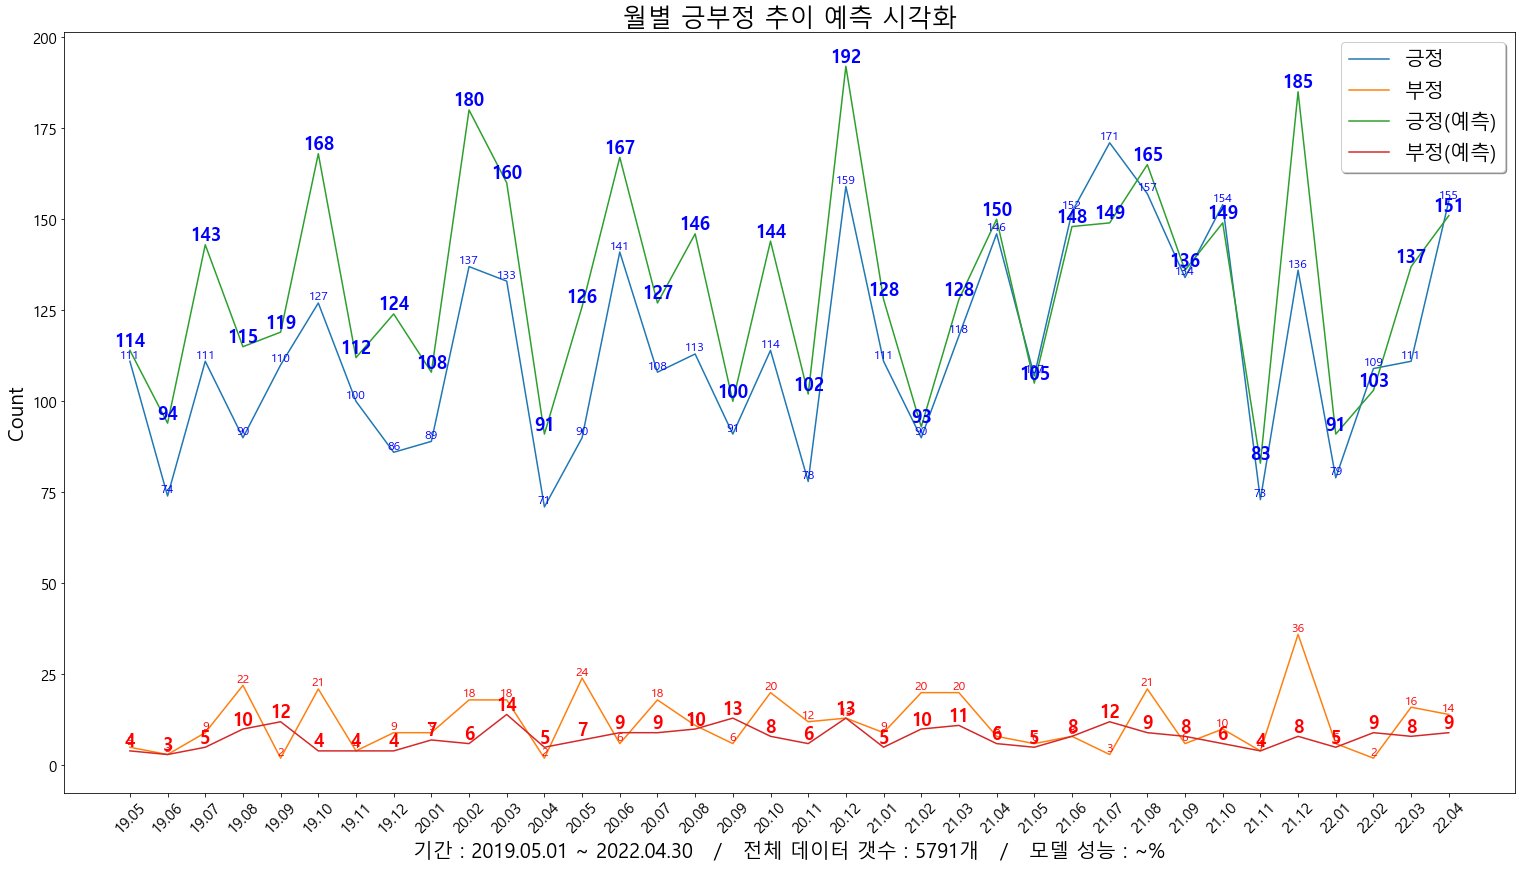

In [86]:
plt.figure(figsize=(26, 14))
for i, v in enumerate(x):
    plt.text(v, pos_raw[i], pos_raw[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 12, color='blue',
             horizontalalignment='center', verticalalignment='bottom')
    
    plt.text(v, neg_raw[i], neg_raw[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 12, color='red', # orange
             horizontalalignment='center', verticalalignment='bottom')
    
#     plt.text(v, mid_raw[i], mid_raw[i],
#              fontsize = 12, color='green',
#              horizontalalignment='center', verticalalignment='bottom')
    
    plt.text(v, pos_pre[i], pos_pre[i],
             fontsize = 18, color='blue', # green
             horizontalalignment='center', verticalalignment='bottom', fontweight= 'heavy')
    
    plt.text(v, neg_pre[i], neg_pre[i],
             fontsize = 18, color='red',
             horizontalalignment='center', verticalalignment='bottom', fontweight= 'heavy')
    
#     plt.text(v, mid_pre[i], mid_pre[i],
#              fontsize = 18, color='green',
#              horizontalalignment='center', verticalalignment='bottom', fontweight= 'heavy')

plt.plot(date_range, pos_raw, label = '긍정')
plt.plot(date_range, neg_raw, label = '부정')# , color='gray')
# plt.plot(date_range, mid_raw, label = '중립')
plt.plot(date_range, pos_pre, label = '긍정(예측)')
plt.plot(date_range, neg_pre, label = '부정(예측)')
# plt.plot(date_range, mid_pre, label = '중립(예측)')

plt.title('월별 긍부정 추이 예측 시각화', size = 25)
plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('기간 : 2019.05.01 ~ 2022.04.30   /   전체 데이터 갯수 : {}개   /   모델 성능 : ~%'.format(len(df_Visualization)), fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(fontsize = 20, shadow=True, loc = 'best')

# 이미지 저장
plt.savefig('./최종산출물/Mutilclass_line_graph.jpg')
plt.show()

In [87]:
df_Visualization.to_csv('./최종산출물/Final_DataSet(Mutilclass).csv')

## 주간별 그래프 ( 특정 월 선택 )

In [101]:
df_select_month = df_Visualization[('2022-04-01' <= df_Visualization['date']) & (df_Visualization['date'] <= '2022-05-01')]

In [102]:
df_select_month.reset_index(inplace=True)
df_select_month.drop(['index'], axis=1, inplace=True)

In [103]:
def decision(state_label):
    global r_cnt1, r_cnt2, r_cnt3
    
    if state_label == '긍정':
        r_cnt1 += 1
    if state_label == '중립':
        r_cnt2 += 1
    if state_label == '부정':
        r_cnt3 += 1

def add_value(x, y, z):
    global r_cnt1, r_cnt2, r_cnt3
    x.append(r_cnt1)
    y.append(r_cnt2)
    z.append(r_cnt3)
    print(x,y,z)
    r_cnt1, r_cnt2, r_cnt3 = 0, 0, 0

In [104]:
start_year = df_select_month['year'][0]
start_month = df_select_month['month'][0]
pos_pre, neg_pre, mid_pre = [], [], []
r_cnt1, r_cnt2, r_cnt3 = 0, 0, 0
# print('연도 : {}, 달 : {}'.format(start_year, start_month))
for i in range(len(df_select_month)):
    if (df_select_month['year'][i] == start_year):
        if start_month == df_select_month['month'][i]:
            decision(df_select_month['predict_label'][i])
        else:
            decision(df_select_month['predict_label'][i])  # 하나의 데이터 누락 추가
            start_month += 1
            add_value(pos_pre, mid_pre, neg_pre)
#             print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_pre, mid_pre, neg_pre))
#             print('달 : {}'.format(start_month))
            
    else: # 하나의 데이터 누락
        if (r_cnt1 >= 0) and (r_cnt2 >= 0) and (r_cnt3 >= 0): # 전년도 12월 긍부정 갯수
            add_value(pos_pre, mid_pre, neg_pre)
            print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_pre, mid_pre, neg_pre))
#         print()
        start_year += 1
        start_month = 1 # 1월로 초기화
#         print('연도 : {}, 달 : {}'.format(start_year, start_month))
    
print(len(pos_pre), len(mid_pre), len(neg_pre)) # 36개가 떠야함.

[152] [24] [9]
1 1 1


In [105]:
last_year, last_month = map(int, df_select_month['date'].tail(1).tolist()[0][:7].split('-'))
# 2021년도부터 시작
def next_date_get(y, x):
    global last_date
    year = y
    for i in range(len(x)):
        if (year == last_year) and (x[i] == last_month + 1):
            return
        if (x[i] % 12) != 0:
            if x[i] < 10:
                x.insert(i, '{}.0'.format(str(year)) + str(x.pop(i)))
            else:
                x.insert(i, '{}.'.format(str(year)) + str(x.pop(i)))
        else:
            x.insert(i, '{}.'.format(str(year)) + str(x.pop(i))) # 12월까지 카운트
            year += 1 # 다음년도
    return x

x = []
# 월별로 정렬이 되어 있으므로 21 ~ 22년도 사이 지정 해주어야 함.
check_year = [False] * len(df_select_month['year'].unique().tolist())

y_unique = df_select_month['year'].unique().tolist()
for i in range(len(check_year)):
    try: 
        x += next_date_get(y_unique[i], df_select_month['month'].unique().tolist())
    except TypeError:
        break
        
tmp_a, tmp_b = df_select_month.groupby('month')['date'].count().tolist()[4:], df_select_month.groupby('month')['date'].count().tolist()[:4]
y = tmp_a + tmp_b

print(x[:5]) # 월
# print('2021.05 ~ :', y) # 값
for i in range(len(x)):
    x[i] = x[i][2:] 
print(x[:5])
date_range = x[0]

['2022.04', '2022.05']
['22.04', '22.05']


In [106]:
plt.figure(figsize=(26, 14))
for i, v in enumerate(x):
#     plt.text(v, pos_raw[i], pos_raw[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
#              fontsize = 12, color='blue',
#              horizontalalignment='center', verticalalignment='bottom')
    
#     plt.text(v, neg_raw[i], neg_raw[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
#              fontsize = 12, color='red', # orange
#              horizontalalignment='center', verticalalignment='bottom')
    
#     plt.text(v, mid_raw[i], mid_raw[i],
#              fontsize = 12, color='green',
#              horizontalalignment='center', verticalalignment='bottom')
    
    plt.text(v, pos_pre[i], pos_pre[i],
             fontsize = 18, color='blue', # green
             horizontalalignment='center', verticalalignment='bottom', fontweight= 'heavy')
    
    plt.text(v, neg_pre[i], neg_pre[i],
             fontsize = 18, color='red',
             horizontalalignment='center', verticalalignment='bottom', fontweight= 'heavy')
    
    plt.text(v, mid_pre[i], mid_pre[i],
             fontsize = 18, color='green',
             horizontalalignment='center', verticalalignment='bottom', fontweight= 'heavy')

# plt.plot(date_range, pos_raw, label = '긍정')
# plt.plot(date_range, neg_raw, label = '부정')# , color='gray')
# plt.plot(date_range, mid_raw, label = '중립')
plt.plot(date_range, pos_pre, label = '긍정(예측)')
plt.plot(date_range, neg_pre, label = '부정(예측)')
plt.plot(date_range, mid_pre, label = '중립(예측)')

plt.title('월별 긍부정 추이 예측 시각화', size = 25)
plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('기간 : 2019.05.01 ~ 2022.04.30   /   전체 데이터 갯수 : {}개   /   모델 성능 : ~%'.format(len(df_select_month)), fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(fontsize = 20, shadow=True, loc = 'best')

# 이미지 저장
# plt.savefig('./최종산출물/line_graph.jpg')
plt.show()

IndexError: list index out of range

ConversionError: Failed to convert value(s) to axis units: '22.04'

<Figure size 1872x1008 with 1 Axes>

## [막대 그래프] 전체 데이터에 대한 예측 시각화 (테스트데이터)

In [89]:
df_Visualization_Total = df_Visualization.copy()

In [92]:
def change_idx(labels):
    idx_tmp = list()
    value_tmp = list()
    for i in pd.Series(labels).unique():
        if i == 0:
            idx_tmp.append('부정')
        if i == 1:
            idx_tmp.append('중립')
        if i == 2:
            idx_tmp.append('긍정')
        value_tmp.append(list(labels).count(i))
    return value_tmp, idx_tmp

In [93]:
r_value_tmp, r_idx_tmp = change_idx(original_labels)
ori_view = pd.Series(data = r_value_tmp, index = r_idx_tmp)
ori_view.sort_index(ascending=True, inplace=True)

x = list(ori_view.keys())
y = ori_view.values

In [94]:
p_value_tmp, p_idx_tmp = change_idx(predict_labels)
pre_view = pd.Series(data = p_value_tmp, index = p_idx_tmp)
pre_view.sort_index(ascending=True, inplace=True)

w = list(pre_view.keys())
z = pre_view.values

In [95]:
df_Visualization_Total = pd.DataFrame({'raw_label' : 0,
              'predict_label' : 0}, index = ['긍정', '부정', '중립'])

In [96]:
idx = 0
for i, j in zip(df_Visualization_Total['raw_label'].index, df_Visualization_Total['predict_label'].index):
    # print(p_value_tmp[p_idx_tmp.index(i)])
    df_Visualization_Total['raw_label'][i] = r_value_tmp[r_idx_tmp.index(i)]
    df_Visualization_Total['predict_label'][j] = p_value_tmp[p_idx_tmp.index(i)]

# df_Visualization_Total['raw_label']['전체'] = len(df_Visualization['raw_label'])
# df_Visualization_Total['predict_label']['전체'] = len(df_Visualization['predict_label'])

In [97]:
df_Visualization_Total

,raw_label,predict_label
긍정,4139,4734
부정,421,276
중립,1231,781


In [98]:
print('테스트 데이터 셋 예측')
Calculation = list(df_Visualization_Total['predict_label'] / df_Visualization_Total['raw_label'])
row = list(df_Visualization_Total.index)
for idx in range(len(Calculation)):
    print('{} :'.format(row[idx]), end=' ')
    if Calculation[idx] > 1:
        print('{:.2f} %'.format((2 - Calculation[idx]) * 100))
    else:
        print('{:.2f} %'.format(Calculation[idx] * 100))

테스트 데이터 셋 예측
긍정 : 85.62 %
부정 : 65.56 %
중립 : 63.44 %


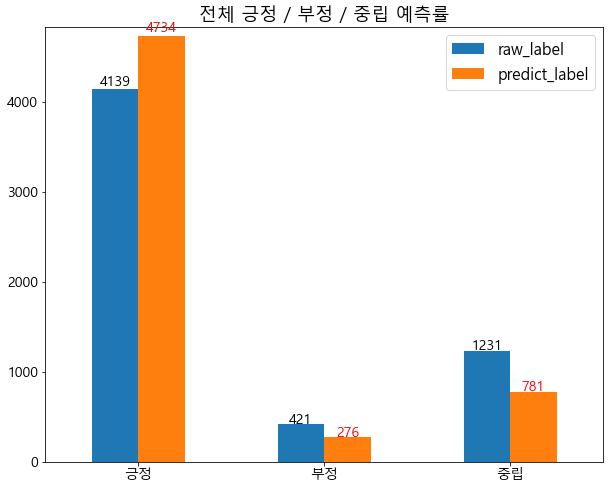

In [99]:
ax = df_Visualization_Total.plot(kind = 'bar', figsize = (10, 8), fontsize=14, rot=0)
graph_value = list(df_Visualization_Total['raw_label']) + list(df_Visualization_Total['predict_label']) + list(['end'])
jump = 0
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    if jump < 3:
        ax.annotate('{}'.format(graph_value.pop(0)), (left+width/2, height*1.01), ha='center', color = 'black', fontsize = 14)
    else:
        ax.annotate('{}'.format(graph_value.pop(0)), (left+width/2, height*1.01), ha='center', color = 'red', fontsize = 14)
    jump += 1

# plt.title("긍정 / 부정 / 중립 예측률", size = 16)
plt.ylim(0, max(max(y), max(z)) + 100)
plt.rc('legend', fontsize=16)  # 범례 폰트 크기
plt.legend()
plt.title('전체 긍정 / 부정 / 중립 예측률', size = 18)
plt.savefig('savefig_default.jpg')
plt.show()